In [117]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
# from kernels.squared_exponential import SquaredExponential
# from kernels.matern import Matern
from torch.optim import Adam

# import sys
import math
# sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Tests and Sanity Checks/')
from efgpnd import EFGPND
import warnings
# warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# Generating some synthetic data

In [118]:


# --- Parameters ---
n = 1_000  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.2
true_variance = 1
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

kernel_type = "Matern32"


Using device: cpu


In [119]:
# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 20
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

In [120]:
from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern

# # For squared exponential kernel
if kernel_type == "SquaredExponential":
    samples = sample_gp_fast(
        x,
        length_scale=true_length_scale,
        variance=true_variance,
        noise_variance=true_noise_variance
    )

elif kernel_type == "Matern32":
    samples = sample_gp_matern(
        x,
        nu=1.5,  # 3/2 Matern
        length_scale=true_length_scale,
        variance=true_variance,
        noise_variance=true_noise_variance
    )
y= samples
# y = samples_se


# Using EFGPND 

In [121]:
d= 2 
EPSILON = 1e-3 # bound on kernel error 
cg_tol = EPSILON 

## Hyperparameter learning
    Note that compute_gradients by default puts the grads in model._gp_params.hyper.rawgrad so that optimizer can use them.

In [122]:
# max_iters = 50
# J = 10
# from torch.optim import Adam


# # Create history dictionary to track parameters
# history = {
#     'lengthscale': [],
#     'variance': [],
#     'sigmasq': [],
#     'log_marginal_likelihood': []
# }



# ## hyper learning with Adam
# # note that compute_gradients() saves grads in model._gp_params so that we can step 
# # also, I hooked optimizer.step() to sync_parameters() so that the kernel is updated after each step
# # so that compute gradients is always called with the latest kernel hyperparameters
# model = EFGPND(x, y, "SquaredExponential", eps= EPSILON)
# optimizer = Adam(model.parameters(), lr=0.1)
# for it in range(max_iters):
#     optimizer.zero_grad()
#     if it % 10 == 0:
#         model.compute_gradients(
#                 trace_samples=J,
#                 # compute_log_marginal=True
#             )
#     else:
#         model.compute_gradients(
#                 trace_samples=J,
#             )

#     optimizer.step() 

#     #### Record history of parameters
#     lengthscale = model.kernel.get_hyper('lengthscale')
#     variance = model.kernel.get_hyper('variance')
#     sigmasq = model._gp_params.sig2.item()
    
#     history['lengthscale'].append(lengthscale)
#     history['variance'].append(variance)
#     history['sigmasq'].append(sigmasq)
#     history['log_marginal_likelihood'].append(log_marginal_likelihood.item())
    
#     if it % 10 == 0:
#         print(f"[ε={EPSILON} | J={J}] iter {it:>3}  "
#             f"ℓ={lengthscale:.4g}  "
#             f"σ_f²={variance:.4g}  σ_n²={sigmasq:.4g}")
#         print(f"log marginal likelihood: {log_marginal_likelihood:.4g}")

# print(f'Final hyperparams: ℓ={lengthscale:.4g}, σ_f²={variance:.4g}, σ_n²={sigmasq:.4g}')

# lengthscale_history = history['lengthscale']
# variance_history = history['variance']
# sigmasq_history = history['sigmasq']

In [123]:
max_iters = 50
J = 10

# Initialize training log
training_log = {
    'iter': [],
    'lengthscale': [],
    'variance': [],
    'sigmasq': [],
}

model = EFGPND(x, y, kernel=kernel_type, eps=EPSILON)
optimizer = Adam(model.parameters(), lr=0.1)

for it in range(max_iters):
    optimizer.zero_grad()
    model.compute_gradients(trace_samples=J)
    optimizer.step() 

    # Record current hyperparameters in the log
    lengthscale = model.kernel.get_hyper('lengthscale')
    variance = model.kernel.get_hyper('variance')
    sigmasq = model._gp_params.sig2.item()
    training_log['iter'].append(it)
    training_log['lengthscale'].append(lengthscale)
    training_log['variance'].append(variance)
    training_log['sigmasq'].append(sigmasq)

    if it % 10 == 0:
        print(f"[ε={EPSILON} | J={J}] iter {it:>3}  "
              f"ℓ={lengthscale:.4g}  "
              f"σ_f²={variance:.4g}  σ_n²={sigmasq:.4g}")

print(f'Final hyperparams: ℓ={lengthscale:.4g}, σ_f²={variance:.4g}, σ_n²={sigmasq:.4g}')


[ε=0.001 | J=10] iter   0  ℓ=0.9426  σ_f²=1.285  σ_n²=0.257
[ε=0.001 | J=10] iter  10  ℓ=0.3806  σ_f²=3.142  σ_n²=0.4314
[ε=0.001 | J=10] iter  20  ℓ=0.3056  σ_f²=3.422  σ_n²=0.2961
[ε=0.001 | J=10] iter  30  ℓ=0.3642  σ_f²=2.33  σ_n²=0.1959
[ε=0.001 | J=10] iter  40  ℓ=0.3021  σ_f²=2.223  σ_n²=0.2058
Final hyperparams: ℓ=0.2755, σ_f²=1.956, σ_n²=0.2275


In [124]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RBF,WhiteKernel, ConstantKernel

# Assume x, y are already defined as numpy arrays of shape (n_samples, n_features) and (n_samples,)
# Use Matern 3/2 kernel with automatic hyperparameter optimization, including noise variance
if kernel_type == "Matern32":
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale_bounds=(1e-2, 1e2), nu=1.5) + WhiteKernel(noise_level_bounds=(1e-5, 1e1))
else:
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level_bounds=(1e-5, 1e1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gp.fit(x, y)

print("Learned kernel:", gp.kernel_)
print("Kernel hyperparameters:", gp.kernel_.get_params())
# Extract the learned variance (signal variance), length scale, and noise variance from the fitted kernel
# For the kernel: ConstantKernel * Matern + WhiteKernel
# The signal variance is the value of the ConstantKernel, the length scale is from the Matern kernel,
# and the noise variance is from the WhiteKernel

learned_kernel = gp.kernel_

# Extract variance (ConstantKernel's constant_value), length scale, and noise variance
if hasattr(learned_kernel, 'k1') and hasattr(learned_kernel.k1, 'k1'):
    scikit_variance = learned_kernel.k1.k1.constant_value
    scikit_length_scale = learned_kernel.k1.k2.length_scale
    scikit_noise_variance = learned_kernel.k2.noise_level
else:
    # fallback for other kernel structures
    scikit_variance = learned_kernel.k1.constant_value
    scikit_length_scale = learned_kernel.k2.length_scale
    scikit_noise_variance = learned_kernel.k2.noise_level

print("Learned variance (signal variance):", float(scikit_variance))
print("Learned length scale:", float(scikit_length_scale))
print("Learned noise variance:", float(scikit_noise_variance))


Learned kernel: 1.06**2 * Matern(length_scale=0.22, nu=1.5) + WhiteKernel(noise_level=0.205)
Kernel hyperparameters: {'k1': 1.06**2 * Matern(length_scale=0.22, nu=1.5), 'k2': WhiteKernel(noise_level=0.205), 'k1__k1': 1.06**2, 'k1__k2': Matern(length_scale=0.22, nu=1.5), 'k1__k1__constant_value': np.float64(1.1301672068190842), 'k1__k1__constant_value_bounds': (0.001, 1000.0), 'k1__k2__length_scale': np.float64(0.21958182325245668), 'k1__k2__length_scale_bounds': (0.01, 100.0), 'k1__k2__nu': 1.5, 'k2__noise_level': np.float64(0.2049481010967183), 'k2__noise_level_bounds': (1e-05, 10.0)}
Learned variance (signal variance): 1.1301672068190842
Learned length scale: 0.21958182325245668
Learned noise variance: 0.2049481010967183


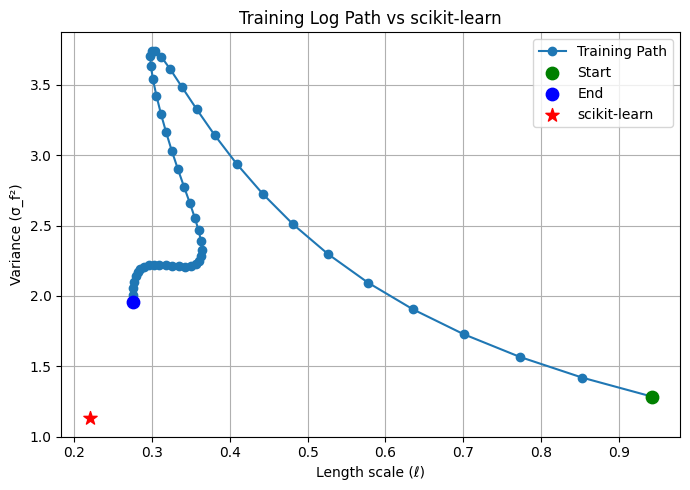

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have lists or arrays of the training log for lengthscale and variance
# For example, if you logged them as lists during training:
# lengthscale_log = [...]
# variance_log = [...]

# If you don't have them, but have only the final values, you can just plot the final point.
# Here, we assume lengthscale_log and variance_log exist and are in order of optimization steps.

# Convert to numpy arrays for plotting
lengthscale_log = training_log['lengthscale']
variance_log = training_log['variance']

plt.figure(figsize=(7, 5))
plt.plot(lengthscale_log, variance_log, marker='o', label='Training Path', color='C0')
plt.scatter(lengthscale_log[0], variance_log[0], color='green', s=80, label='Start', zorder=5)
plt.scatter(lengthscale_log[-1], variance_log[-1], color='blue', s=80, label='End', zorder=5)

# Plot scikit-learn learned values
plt.scatter([scikit_length_scale], [scikit_variance], color='red', s=100, marker='*', label='scikit-learn', zorder=10)

plt.xlabel('Length scale (ℓ)')
plt.ylabel('Variance (σ_f²)')
plt.title('Training Log Path vs scikit-learn')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Fitting posterior mean

In [126]:
# Time different variance estimation methods
import time

# No variance
start_time = time.time()
mean_no_var, _= model.predict(x_new, return_variance=False)
no_var_time = time.time() - start_time
print(f"Time without variance: {no_var_time:.4f} seconds; x_new.shape = {x_new.shape}")


Time without variance: 0.1773 seconds; x_new.shape = torch.Size([400, 2])


## Posterior variance -- Stochastic Estimate

In [127]:
start_time = time.time()
hutchinson_probes = 100
mean, stoch_var = model.predict(x_new, return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
stoch_var_time = time.time() - start_time
print(f"Time with stochastic variance, x_new.shape = {x_new.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")




Time with stochastic variance, x_new.shape = torch.Size([400, 2]), 100 probes: 4.4017 seconds


## Posterior variance -- regular method

In [128]:
# Regular variance
start_time = time.time()
mean, var = model.predict(x_new, return_variance=True, variance_method="regular")
reg_var_time = time.time() - start_time
print(f"Time with regular variance, x_new.shape = {x_new.shape}: {reg_var_time:.4f} seconds")

Time with regular variance, x_new.shape = torch.Size([400, 2]): 19.6268 seconds


Maybe update idea- Context variables instead of all the opts 
- with .... settings = exact... 